In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

filename = "/data/fast0/datasets/Rhone_data_continuous.h5"
f = h5py.File(filename, 'r')
print("Keys: %s" % f.keys())

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>


In [2]:
# Put data in a data frame
das = np.transpose([chan[750] for chan in f['DAS Data']])

# Might want to try this later:
# das = np.log10(np.transpose([chan[750] for chan in f['DAS Data']]))

discharge = np.array(f['Discharge'])
df = pd.DataFrame(data={'das':das,'discharge':discharge})

Text(0, 0.5, 'Discharge')

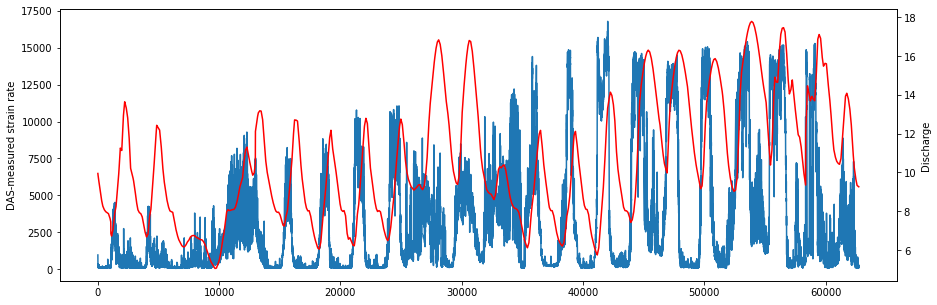

In [3]:
# Plot the raw data

fig,ax=plt.subplots(figsize=(15,5))
ax.plot(das)
ax.set_ylabel('DAS-measured strain rate')
ax2=plt.twinx()
ax2.plot(discharge,'-r')
ax2.set_ylabel('Discharge')

In [4]:
# Split the data
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [5]:
# Normalize
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

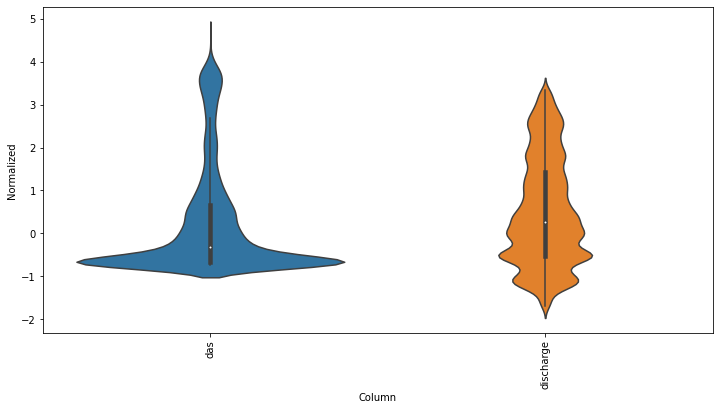

In [6]:
# Visualize the normalized data
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [7]:
class WindowGenerator():
    
    @property
    def train(self):
      return self.make_dataset(self.train_df)

    @property
    def val(self):
      return self.make_dataset(self.val_df)

    @property
    def test(self):
      return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)

        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result


    def __init__(self, input_width, label_width, shift,
               train_df=train_df, 
               val_df=val_df, 
               test_df=test_df,
               label_columns=None,
               input_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}
        
        # Do the same for the input column indices.
        self.input_columns = input_columns
        if input_columns is not None:
            self.input_columns_indices = {name: i for i, name in
                                        enumerate(input_columns)}
        self.input_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Input column name(s): {self.input_columns}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def split_window(self, ds):
        inputs = ds[:, self.input_slice, :]
        labels = ds[:, self.labels_slice, :]
#         print(inputs)

        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)
            
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels

In [14]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=0,
    label_columns=['discharge'],
    input_columns=['das'])
single_step_window

Total window size: 1
Input indices: [0]
Input column name(s): ['das']
Label indices: [0]
Label column name(s): ['discharge']

In [35]:
list(single_step_window.test.as_numpy_iterator())

[(array([[[-0.72325987]],
  
         [[ 0.16463561]],
  
         [[-0.58630306]],
  
         [[-0.65391773]],
  
         [[-0.28845835]],
  
         [[ 4.1025076 ]],
  
         [[ 0.36063984]],
  
         [[-0.7130837 ]],
  
         [[-0.673289  ]],
  
         [[-0.46514648]],
  
         [[ 0.08926968]],
  
         [[-0.56325066]],
  
         [[-0.24404322]],
  
         [[ 0.38973838]],
  
         [[-0.57642776]],
  
         [[-0.3915394 ]],
  
         [[ 0.51928836]],
  
         [[ 1.1166978 ]],
  
         [[-0.6691446 ]],
  
         [[ 3.0730555 ]],
  
         [[ 2.8210418 ]],
  
         [[-0.26229456]],
  
         [[ 0.04572187]],
  
         [[ 1.8403804 ]],
  
         [[ 2.8255887 ]],
  
         [[-0.33336288]],
  
         [[-0.7216856 ]],
  
         [[-0.6088331 ]],
  
         [[ 0.653933  ]],
  
         [[-0.70181745]],
  
         [[-0.40863666]],
  
         [[ 0.12141235]]], dtype=float32),
  array([[[ 2.073225  ]],
  
         [[ 1.626015  ]],
  


In [9]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(1)
])

In [10]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [27]:
history = compile_and_fit(linear, single_step_window)

val_performance={}
performance={}
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
1373/1373 [==============================] - 2s 1ms/step - loss: 0.9875 - mean_absolute_error: 0.7890 - val_loss: 3.5537 - val_mean_absolute_error: 1.6337
Epoch 2/20
1373/1373 [==============================] - 1s 856us/step - loss: 0.9875 - mean_absolute_error: 0.7890 - val_loss: 3.5432 - val_mean_absolute_error: 1.6312
Epoch 3/20
1373/1373 [==============================] - 1s 770us/step - loss: 0.9875 - mean_absolute_error: 0.7890 - val_loss: 3.5554 - val_mean_absolute_error: 1.6342
Epoch 4/20
393/393 [==============================] - 0s 640us/step - loss: 3.5536 - mean_absolute_error: 1.6337


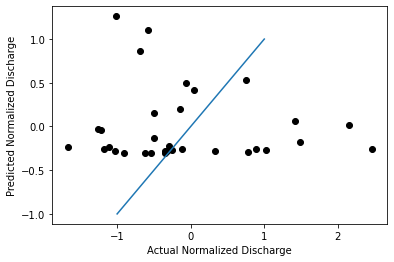

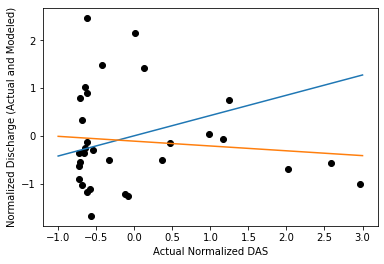

In [64]:
inputs, labels = single_step_window.example

predictions = np.array(linear(inputs)).flatten()
inputs = np.array(inputs).flatten()
labels = np.array(labels).flatten()

plt.subplots()
plt.plot(labels,predictions,'ok')
plt.plot((-1,1),(-1,1))
plt.xlabel('Actual Normalized Discharge')
plt.ylabel('Predicted Normalized Discharge')

plt.subplots()
plt.plot(inputs, labels,'ok')
# for xx, yy in single_step_window.val.take(5):
#     plt.plot(np.array(xx[:,0,:]).flatten(),np.array(yy).flatten(),'or')
plt.xlabel('Actual Normalized DAS')
plt.ylabel('Normalized Discharge (Actual and Modeled)')
weights=linear.layers[0].kernel[:,0].numpy()
biases=linear.layers[0].bias.numpy()
plt.plot((-1,3.0),weights[0]*np.array((-1,3.0))+biases[0])

# Compare to linear least squares
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(inputs,labels)
plt.plot((-1,3.0),slope*np.array((-1,3.0))+intercept)

In [48]:
multi_step_window = WindowGenerator(
    input_width=1000, label_width=1, shift=0,
    label_columns=['discharge'],
    input_columns=['das'])
# multi_step_window

In [49]:
history = compile_and_fit(linear, multi_step_window)

Epoch 1/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8583 - mean_absolute_error: 0.7184 - val_loss: 2.3878 - val_mean_absolute_error: 1.3542
Epoch 2/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8429 - mean_absolute_error: 0.7042 - val_loss: 2.3827 - val_mean_absolute_error: 1.3524
Epoch 3/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8429 - mean_absolute_error: 0.7040 - val_loss: 2.3860 - val_mean_absolute_error: 1.3536
Epoch 4/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8429 - mean_absolute_error: 0.7041 - val_loss: 2.3750 - val_mean_absolute_error: 1.3495
Epoch 5/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8429 - mean_absolute_error: 0.7041 - val_loss: 2.3778 - val_mean_absolute_error: 1.3505
Epoch 6/20
1342/1342 [==============================] - 2s 1ms/step - loss: 0.8429 - mean_absolute_error: 0.7041 - val_loss: 2.3705 - val_mean_absolute_error: 1.3478
Epoc

In [65]:
val_performance['Multistep_Linear'] = linear.evaluate(multi_step_window.val)
performance['Multistep_Linear'] = linear.evaluate(multi_step_window.test, verbose=0)
performance

361/361 [==============================] - 1s 1ms/step - loss: 2.3840 - mean_absolute_error: 1.3528


{'Multistep_Linear': [2.3924965858459473, 1.3503639698028564],
 'Linear': [3.034050941467285, 1.5278613567352295]}